###Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Accessing Data


In [2]:
import os
import zipfile

In [3]:
FLDR="drive/MyDrive/COVID-CTset/"

In [4]:
FLDR_w="drive/MyDrive/COVID/"

In [5]:
fldrs=os.listdir(FLDR)

In [6]:
fldrs

['COVID-CTset.zip', 'Train&Validation.zip', 'CSV', 'trained_networks']

In [10]:
fldr_req='Train&Validation.zip'

In [11]:
archive=zipfile.ZipFile(FLDR+fldr_req)

In [ ]:
for f_n in archive.namelist():
  archive.extract(f_n,FLDR_w+'data')

In [5]:
Fldr_f="drive/MyDrive/COVID/data"

In [6]:
files=os.listdir(Fldr_f)

In [7]:
len(files)

12058

In [8]:
import pandas as pd

In [9]:
fldr_meta=FLDR+'CSV/'

In [10]:
files_meta=os.listdir(fldr_meta)

In [11]:
files_meta

['test1.csv',
 'train1.csv',
 'test2.csv',
 'train2.csv',
 'test3.csv',
 'train5.csv',
 'test4.csv',
 'train4.csv',
 'train3.csv',
 'test5.csv',
 'validation2.csv',
 'validation1.csv',
 'validation4.csv',
 'validation3.csv',
 'validation5.csv',
 'Patient_details.csv']

In [12]:
filename=Fldr_f+"137covid_patient1_SR_2_IM00010.tif"

In [12]:
import cv2

In [14]:
filename

'drive/MyDrive/COVID/data137covid_patient1_SR_2_IM00010.tif'

In [15]:
img=cv2.imread(Fldr_f+"/137covid_patient1_SR_2_IM00010.tif",cv2.IMREAD_UNCHANGED)

In [16]:
img.shape

(512, 512)

In [13]:
files_meta=['train1.csv','test1.csv','validation1.csv']

In [14]:
df_meta=pd.DataFrame()
for file in files_meta:
  df_t=pd.read_csv(fldr_meta+file)
  print(len(df_t))
  if len(df_meta)==0:
    df_meta=df_t
  else:
    df_meta=pd.concat([df_meta,df_t])


3736
8322
912


In [15]:
df_meta.head()

,filename,class
0,137covid_patient1_SR_2_IM00010.tif,covid
1,137covid_patient1_SR_2_IM00011.tif,covid
2,137covid_patient1_SR_2_IM00012.tif,covid
3,137covid_patient1_SR_2_IM00013.tif,covid
4,137covid_patient1_SR_2_IM00014.tif,covid


In [20]:
Images=[]
Labels=[]

In [ ]:
for i in range(len(df_meta)):
  filename=Fldr_f+'/'+df_meta.iloc[i]['filename']
  if i%100==0:
    print(i)

  img=cv2.imread(filename,cv2.IMREAD_UNCHANGED)
  img=img.reshape(512,512)
  img=cv2.resize(img,(256,256))
  Images.append(img)
  if df_meta.iloc[i]['class']=='covid':
    label=1
  else:
    label=0
  Labels.append(label)
  print(filename+ " done")

  

In [22]:
len(Images)

12970

In [23]:
import numpy as np


### Modelling

In [26]:
!pip install git+https://github.com/mr7495/RetinaNet

  Cloning https://github.com/mr7495/RetinaNet to /tmp/pip-req-build-69b105a5
  Running command git clone -q https://github.com/mr7495/RetinaNet /tmp/pip-req-build-69b105a5
  Running command git submodule update --init --recursive -q
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp37-cp37m-linux_x86_64.whl size=181938 sha256=02939a1e7e8b78a21870793800db4a8332316eb13f1079375c5237e0a49740cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-cr8uq_yk/wheels/08/6d/f5/38473102b36a5975e02e8f339fbf85bc4d1b1c7c80dc68a595
Successfully built keras-retinanet


In [87]:
import keras
import numpy as np
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras_retinanet import layers
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input
from keras.applications.resnet_v2 import ResNet50V2
from keras.initializers import RandomNormal

In [88]:
### Model

In [89]:
fldr="drive/MyDrive/COVID/MISC/"

In [90]:
weight_model = ResNet50V2(weights='imagenet', include_top=False)   ##Initializing Resnet50v2 model
weight_model.save_weights(fldr+'weights.h5')                       ##Saving wieghts

In [91]:
def model(shape=(256,256,1)):
  input_tensor=Input(shape=shape)  ## Setting Input Size
  feature_size=256                ## Setting Feature Size

  base_model = ResNet50V2(weights=None, include_top=False, input_tensor=input_tensor)   ##Initializing new base model
  base_model.load_weights(fldr+'weights.h5',skip_mismatch=True, by_name=True)    ##loading the weights (Transfer Learning)
  layer_names = ["conv4_block1_preact_relu", "conv5_block1_preact_relu", "post_relu"]    ## Layers of Resnet50v2 we need to learn from
  layer_outputs = [base_model.get_layer(name).output for name in layer_names]         ##Taking the output of the layers for creating the feature pyramid


  ## Layers for FPN

  C3, C4, C5= layer_outputs ##Bottom Up limb

  

  ## Top down limb

  ## First Layer from top
  P5= keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C5_reduced')(C5) ## 256 feature map 1x1 kernel for reducing dimension
  P5_upsampled = layers.UpsampleLike(name='P5_upsampled')([P5, C4])   ## Upsampling layer, doubling size using nearest neighbours interpolation for concatenation
  P5= keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, padding='same', name='P5')(P5)   ### 3x3 convolution  ## Output feature 

  ## Second Layer from top 
  P4= keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C4_reduced')(C4) ## 1x1 for dimension reduction
  P4= keras.layers.Concatenate(axis=3)([P5_upsampled, P4]) ### Creating the link between the bottom up and top down limb to decrease aliasing
  P4_upsampled= layers.UpsampleLike(name='P4_upsampled')([P4, C3])  ## Upsampled
  P4= keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, name='P4')(P4)   ## output feature  

  ## Third Layer from top 
  P3 = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C3_reduced')(C3) ##1x1 for dimension reduction
  P3 = keras.layers.Concatenate(axis=3)([P4_upsampled, P3])   ##Concat
  P3 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, name='P3')(P3) ### Output Feature

  ## First Layer from top 2nd feature
  P6 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=2, padding='same', name='P6')(C5)   ## Output feature

  ## First Layer from top 3rd feature 
  P7 = keras.layers.Activation('relu', name='C6_relu')(P6)         ## activation is applied
  P7 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=2, padding='same', name='P7')(P7)   ## Output Feature


  ## Flattening and obtaining features

  ## Feature 1
  feature1 = Flatten()(P3)
  dp1 = Dropout(0.5)(feature1)
  preds1 = Dense(2, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp1)  ## results from first set of features

  ## Feature 2
  feature2 = Flatten()(P4)
  dp2 = Dropout(0.5)(feature2)
  preds2 = Dense(2, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp2)

  ## Feature 3
  feature3 = Flatten()(P5)
  dp3= Dropout(0.5)(feature3)
  preds3 = Dense(2, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp3)

  ## Feature 4
  feature4 = Flatten()(P6)
  dp4 = Dropout(0.5)(feature4)
  preds4 = Dense(2, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp4)

  ## Feature 5
  feature5 = Flatten()(P7)
  dp5 = Dropout(0.5)(feature5)
  preds5 = Dense(2, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp5)

  ### Combining all individual features preds
  concat=keras.layers.Concatenate(axis=1)([preds1,preds2,preds3,preds4,preds5])
  out=keras.layers.Dense(1,activation='sigmoid',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(concat) ## Final Predictions

  model = Model(inputs=base_model.input, outputs=out)
  for layer in model.layers:
    layer.trainable = True
  model.compile(optimizer=optimizers.Nadam(lr=0.0001), loss='binary_crossentropy',metrics=['accuracy'])

  return model



In [92]:
Model=model()

In [93]:
Model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 1)  0           input_19[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [94]:
from keras.utils.vis_utils import plot_model

In [95]:
plot_model(Model, to_file=fldr+'model_plot.png', show_shapes=True, show_layer_names=True)

### The diagram is fully reversed.

### Training

In [60]:
import numpy as np

In [61]:
Images_n=np.array(Images, dtype="float32")
Labels_n=np.array(Labels, dtype="float32")

In [62]:
np.save("drive/MyDrive/COVID/MISC/Images_data.npy",Images_n)
np.save("drive/MyDrive/COVID/MISC/Labels_data.npy",Labels_n)

In [7]:
Images_n=np.load("drive/MyDrive/COVID/MISC/Images_data.npy")
Labels_n=np.load("drive/MyDrive/COVID/MISC/Labels_data.npy")

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
X_train, X_test, y_train, y_test = train_test_split(Images_n, Labels_n, test_size=0.25, random_state=42)


In [83]:
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [84]:
checkpoint = ModelCheckpoint("drive/MyDrive/COVID/MISC/Model.h5", monitor='val_accuracy', save_best_only=True, mode='max') #creating checkpoint to save the best validation accuracy
callbacks_list = [checkpoint]

In [97]:
history=Model.fit(X_train,y_train, epochs=20,batch_size=14,validation_data=(X_val,y_val),shuffle=True,callbacks=callbacks_list,verbose=1)

Epoch 1/20
556/556 [==============================] - 100s 134ms/step - loss: 0.1941 - accuracy: 0.9255 - val_loss: 0.1121 - val_accuracy: 0.9645
Epoch 2/20
556/556 [==============================] - 73s 131ms/step - loss: 0.0664 - accuracy: 0.9794 - val_loss: 0.5275 - val_accuracy: 0.8165
Epoch 3/20
556/556 [==============================] - 73s 131ms/step - loss: 0.0352 - accuracy: 0.9883 - val_loss: 0.2210 - val_accuracy: 0.9399
Epoch 4/20
556/556 [==============================] - 73s 131ms/step - loss: 0.0279 - accuracy: 0.9913 - val_loss: 0.0542 - val_accuracy: 0.9897
Epoch 5/20
556/556 [==============================] - 73s 132ms/step - loss: 0.0201 - accuracy: 0.9941 - val_loss: 0.0515 - val_accuracy: 0.9897
Epoch 6/20
556/556 [==============================] - 73s 131ms/step - loss: 0.0188 - accuracy: 0.9941 - val_loss: 0.0362 - val_accuracy: 0.9928
Epoch 7/20
556/556 [==============================] - 73s 131ms/step - loss: 0.0160 - accuracy: 0.9946 - val_loss: 0.0338 - val_a

In [99]:
train_eval=Model.evaluate(x=X_train, y=y_train, batch_size=8 , verbose=1, sample_weight=None, steps=None)
test_eval=Model.evaluate(x=X_test, y=y_test, batch_size=8, verbose=1, sample_weight=None, steps=None)

406/406 [==============================] - 11s 27ms/step - loss: 0.0282 - accuracy: 0.9938


In [100]:
test_eval

[0.028238363564014435, 0.9938328862190247]

In [102]:
import matplotlib.pyplot as plt


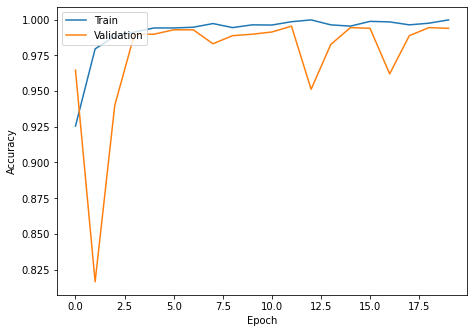

In [103]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

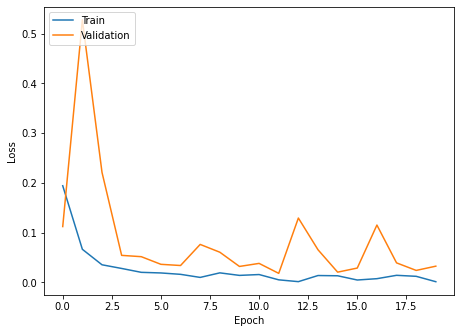

In [104]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()